# Test VOLVuLuS

## Import packages

In [1]:
import VOLVuLuS_settings as settings
from thesis_common import read_preprocess_image, read_preprocess_groundtruth,\
    convert_img_to_pred_3D, convert_pred_to_img_3D, group_images,\
    show_image, create_hdf5_db_3D, read_preprocess_image, read_preprocess_groundtruth

from dltoolkit.utils.generic import list_images
from dltoolkit.nn.segment import UNet_3D_NN
from dltoolkit.utils.visual import plot_roc_curve, plot_precision_recall_curve,\
    print_confusion_matrix, print_classification_report

import os, cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Path to the model to load

In [2]:
TRAINED_MODEL_NAME = "../savedmodels/VOLVuLuS_UNet3D_brain_2layer_no_BN_ep200.model"

## Convert test data to HDF5

## Load data

In [3]:
test_imgs = read_preprocess_image(
    "../data/MSC8002/training_3d/images.h5",
    settings.HDF5_KEY,
    is_3D=True)
test_ground_truths = read_preprocess_groundtruth(
    "../data/MSC8002/training_3d/groundtruths.h5",
    settings.HDF5_KEY,
    is_3D=True)

Loading image HDF5: ../data/MSC8002/training_3d/images.h5 with dtype = float32

Loading ground truth HDF5: ../data/MSC8002/training_3d/groundtruths.h5 with dtype = uint8



## Show one image to check

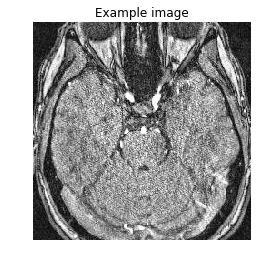

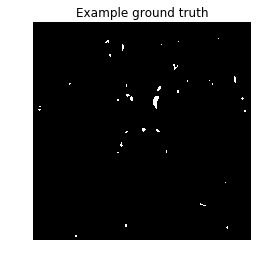

In [4]:
# Show an image plus its ground truth to check
IX_START = 0
PATIENT_ID = 0
show_image(np.squeeze(test_imgs[PATIENT_ID, :, :, IX_START]), 'Example image')

if settings.IS_DEVELOPMENT:
    show_image(np.squeeze(test_ground_truths[PATIENT_ID, :, :, IX_START]), 'Example ground truth')

## Load the trained model

In [5]:
unet = UNet_3D_NN(img_height=settings.IMG_HEIGHT,
                  img_width=settings.IMG_WIDTH,
                  num_slices=settings.SLICE_END - settings.SLICE_START,
                  img_channels=settings.IMG_CHANNELS,
                  num_classes=settings.NUM_CLASSES)
# model = unet.build_model_no_BN()
model = unet.build_model_2lyr()
model.load_weights(TRAINED_MODEL_NAME)
model.summary()

conv_contr1: (?, 240, 240, 8, 32)
conv_contr1: (?, 240, 240, 8, 64)
pool_contr1: (?, 120, 120, 4, 64)
conv_bottom I: (?, 120, 120, 4, 64)
conv_bottom II: (?, 120, 120, 4, 128)
scale_up1: (?, 240, 240, 8, 128)
merge_up1: (?, 240, 240, 8, 192)
conv_up1 I: (?, 240, 240, 8, 64)
conv_up1 II: (?, 240, 240, 8, 64)
final: (?, 240, 240, 8, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 8,  0                                            
__________________________________________________________________________________________________
contr1_1 (Conv3D)               (None, 240, 240, 8,  896         input_1[0][0]                    
__________________________________________________________________________________________________
contr1_2 (Conv3D)               (None, 240, 240, 8,  55360       contr

## Make predictions

In [6]:
predictions = model.predict(test_imgs, batch_size=settings.TRN_BATCH_SIZE, verbose=2)

## Convert predictions to segmentation map images

In [7]:
predictions_imgs = convert_pred_to_img_3D(predictions,
                                       threshold=settings.TRN_PRED_THRESHOLD,
                                       verbose=settings.VERBOSE)

Elapsed time: 0.028734922409057617


## Show segmentation maps

In [8]:
MAX_IMAGES = 10

test_imgs_conv = np.transpose(test_imgs, axes=(0, 3, 1, 2, 4))
test_ground_truths_conv = np.transpose(test_ground_truths, axes=(0, 3, 1, 2, 4))
predictions_conv = np.transpose(predictions, axes=(0, 3, 1, 2, 4))

num_slices = settings.SLICE_END - settings.SLICE_START

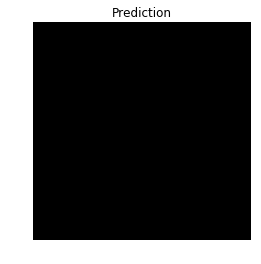

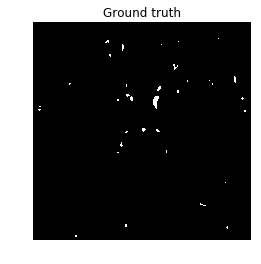

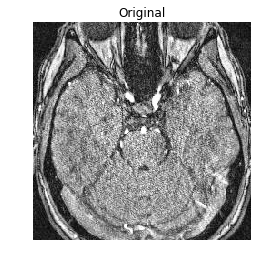

In [9]:
if settings.IS_DEVELOPMENT:
    # Show a single image, ground truth and segmentation map
    tmp_img = predictions_imgs[PATIENT_ID, 0]
    show_image(np.squeeze(tmp_img), 'Prediction')

    tmp_img = test_ground_truths_conv[PATIENT_ID, 0]
    show_image(np.squeeze(tmp_img), 'Ground truth')

    tmp_img = test_imgs_conv[PATIENT_ID, 0]
    show_image(np.squeeze(tmp_img), 'Original')
    
    group_images(test_ground_truths_conv[PATIENT_ID, 0:min(16, num_slices)], 4, 1.0, False, "../output/VOLVuLuS_"+unet.title+"_grp_originals")

group_images(test_imgs_conv[PATIENT_ID, 0:min(16, num_slices)], 4, 1.0, False, "../output/VOLVuLuS_" + unet.title+"_grp_images")
group_images(predictions_imgs[PATIENT_ID, 0:min(16, num_slices)], 4, 1.0, False, "../output/VOLVuLuS_" + unet.title+"_grp_predictions")

print("")

## Show metrics

### ROC curve

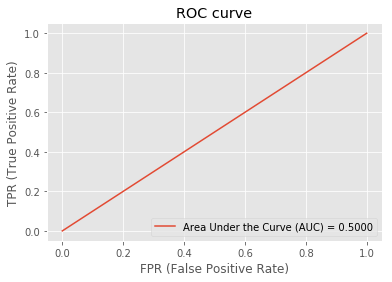

In [10]:
if settings.IS_DEVELOPMENT:
    roc_path = os.path.join(settings.OUTPUT_PATH, "VOLVuLuS_" + unet.title)
    plot_roc_curve(test_ground_truths_conv, predictions_imgs, show=True, save_path=roc_path)

### Precision/recall curve


Area under Precision-Recall curve: 0.5719972688511359


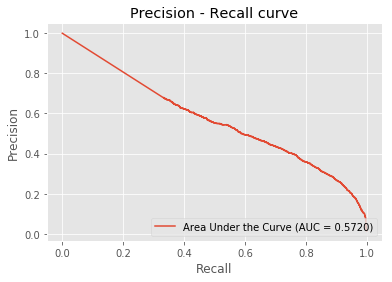

In [11]:
if settings.IS_DEVELOPMENT:
    prec_path = os.path.join(settings.OUTPUT_PATH, "VOLVuLuS_" + unet.title)
    plot_precision_recall_curve(test_ground_truths_conv,
                                predictions_conv,
                                settings.NUM_CLASSES,
                                show=True,
                                save_path=prec_path)

### Confusion matrix

In [12]:
if settings.IS_DEVELOPMENT:
    (conf_ind, conf_mat) = print_confusion_matrix(test_ground_truths_conv, predictions_imgs)

Confusion matrix:
[[458592      0]
 [  2208      0]]
   Row/Column: Negative Class, Positive Class, i.e.:
             TN FP
             FN TP

 True Negative (TN): 458592
 True Positive (TP): 0
False Negative (FN): 2208
False Positive (FP): 0

Blood vessel precision: nan
   Blood vessel recall: 0.00


/Users/geoff/Documents/Development/DLToolkit/dltoolkit/utils/visual.py:173: RuntimeWarning: invalid value encountered in long_scalars
  print("\nBlood vessel precision: {:.2f}".format((tp / (tp + fp))))


### Classification report

In [13]:
if settings.IS_DEVELOPMENT:
    print_classification_report(test_ground_truths_conv, predictions_imgs)

Precision: 0.00
   Recall: 0.00


/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

 background       1.00      1.00      1.00    458592
     vessel       0.00      0.00      0.00      2208

avg / total       0.99      1.00      0.99    460800



/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Write segmentation maps